# Problem1: Improving Your Digit Recognition Model From Assignment 1

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [ ]:

import tensorflow_probability as tfp
import copy

In [ ]:
df=pd.read_csv('/content/German_digits.csv')

In [ ]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,80,...,0,0,0,0,0,0,0,0,0,7
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [ ]:
print(df.shape)

(4426, 1601)


In [ ]:
# The first 1600 columns are the pixel values, and the last column is the label
X = df.iloc[:, :-1].values  # features (pixel values)
Y = df.iloc[:, -1].values   # labels (digits 0-9)

In [ ]:
X = X / 255.0

In [ ]:
# Randomly split  dataset into train and test. Used  train_test_split from sklearn package
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# One-hot encoding the labels
Y_train_onehot = pd.get_dummies(Y_train).values
Y_val_onehot = pd.get_dummies(Y_val).values

In [ ]:
Y_train_onehot.shape

(3540, 10)

In [ ]:
# Transposed the feature matrix and the one-hot encoded labels
X_train_T = X_train.T
X_val_T = X_val.T
Y_train_onehot_T = Y_train_onehot.T
Y_val_onehot_T = Y_val_onehot.T

In [ ]:
print("Train X shape:", X_train_T.shape)
print("Train Y shape:", Y_train_onehot_T.shape)
print("Validation X shape:", X_val_T.shape)
print("Validation Y shape:", Y_val_onehot_T.shape)


Train X shape: (1600, 3540)
Train Y shape: (10, 3540)
Validation X shape: (1600, 886)
Validation Y shape: (10, 886)


In [ ]:
print("Shape of X_train_T:", X_train_T.shape)  # Shape - (num_features, num_samples)
print("Shape of Y_train:", Y_train.shape)      # Shape - (num_classes, num_samples)

Shape of X_train_T: (1600, 3540)
Shape of Y_train: (3540,)


In [ ]:
def initialize_parameters(nx, nh):
  parameters={}
  # Initialize weights and biases for the first layer (input to the first hidden layer)
  parameters['W1'] = tf.Variable(tf.random.uniform(shape=(nh[0], nx), minval=-0.01, maxval=0.01))
  #biases are typically initialized to zeros
  parameters['b1'] = tf.Variable(tf.zeros((nh[0],1)))


  for i in range(1, len(nh)):
    parameters['W'+str(i+1)]=tf.Variable(tf.random.uniform(shape=(nh[i],nh[i-1]), minval=-0.01, maxval=0.01))
    parameters['b'+str(i+1)]=tf.Variable(tf.zeros((nh[i],1)))


  return parameters


parameters= initialize_parameters(1600, [512,256,128,10])
for key, value in parameters.items():
  print(key, value.shape)

W1 (512, 1600)
b1 (512, 1)
W2 (256, 512)
b2 (256, 1)
W3 (128, 256)
b3 (128, 1)
W4 (10, 128)
b4 (10, 1)


In [ ]:
def forward_pass(parameters, X):
    X = tf.cast(X, tf.float32)  # Cast input to float32

    n_layers = len(parameters) // 2  # Number of layers (W and b pairs)

    # First layer (input to first hidden layer)
    Z = tf.matmul(parameters['W1'], X) + parameters['b1']
    A = tf.nn.relu(Z)

    # Loop through remaining hidden layers
    for i in range(1, n_layers - 1):
        Z = tf.matmul(parameters['W' + str(i + 1)], A) + parameters['b' + str(i + 1)]
        A = tf.nn.relu(Z)

    # Final layer (no ReLU, apply softmax for classification)
    Z = tf.matmul(parameters['W' + str(n_layers)], A) + parameters['b' + str(n_layers)]



    A = tf.nn.softmax(Z, axis=0)  # Softmax for multi-class classification



    return A


In [ ]:
#unit testing forward_pass
parameters= initialize_parameters(1600, [512,256,128,10])

Yhat=forward_pass(parameters,X_train_T)
print(Yhat.shape)

In [ ]:
# Check if softmax is working correctly by verifying that the probabilities sum to 1
#Yhat=forward_pass(parameters,X_train_T)
print("Sum of probabilities for first sample:", np.sum(Yhat[:, 0]))  # Should be 1.0

In [ ]:
yhat_val = forward_pass(parameters, X_val_T)
#print("Shape of model output (Validation):", yhat_val.shape)

In [ ]:
#categorical cross entropy loss function
def compute_loss(Y, Yhat):
    # Use TensorFlow's built-in categorical cross-entropy loss for stability
    #loss_per_sample = tf.keras.losses.categorical_crossentropy(Y, Yhat, from_logits=False)
    # Compute categorical cross-entropy loss for multi-class classification
    loss_per_sample = -tf.reduce_sum(Y * tf.math.log(Yhat + 1e-8), axis=0)  # Add small value to avoid log(0)
    return tf.reduce_mean(loss_per_sample)  # Take the mean across all samples

In [ ]:


#  testing loss
# Y_train_onehot_T is the actual one-hot encoded labels
# Yhat is the predicted output from forward_pass
y = Y_train_onehot_T  # Actual one-hot encoded labels
yhat = forward_pass(parameters, X_train_T)
loss = compute_loss(y, yhat)
print(loss)

In [ ]:
def compute_gradients(loss, parameters, tape):
    # Extract the list of variables from the parameters dictionary
    variables = list(parameters.values())
    # Compute the gradients with respect to the loss
    gradients = tape.gradient(loss, variables)
    return gradients

In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    # Zip through both parameters and gradients to apply updates
    for (key, param), grad in zip(parameters.items(), gradients):
        parameters[key].assign_sub(learning_rate * grad)
    return parameters

Improve  Digit Recognition Model:

More specifically, we will add the following components.

 create_nn method with  Mini-batch gradient descent
 - create_nn method should accept an additional parameter (batch_size). Then instead of
updating parameters per entire data, we will create random batches of (batch_size) samples from training
data, run forward and backward passes, and update parameters per each batch. Then to get the train_loss
for each epoch, we should keep track and average train_losses over batches.
1- Retrain the model using mini-batch gradient descent  implemented above and interpret the learning
curves.

• How do training and validation losses compare to the model without minibatch gradient
descent?

In [ ]:
#Referred google
# Function to create random mini-batches
def create_mini_batches(X, Y, batch_size):
    m = X.shape[1]  # Number of training examples
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    mini_batches = []

    num_batches = m // batch_size

    for k in range(num_batches):
        mini_batch_X = shuffled_X[:, k * batch_size:(k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[:, k * batch_size:(k + 1) * batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    # To handle the last mini-batch (if m is not divisible by batch_size)
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_batches * batch_size:]
        mini_batch_Y = shuffled_Y[:, num_batches * batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    return mini_batches

In [ ]:
#Referred google



def create_nn(train_X, train_Y, val_X, val_Y, nh, learning_rate, iterations, batch_size):
    # Initialize parameters
    parameters = initialize_parameters(train_X.shape[0], nh)
    train_loss_history = []
    val_loss_history = []

    for i in range(iterations):
        mini_batches = create_mini_batches(train_X, train_Y, batch_size)
        epoch_train_losses = []

        for (mini_batch_X, mini_batch_Y) in mini_batches:
            # Compute train loss and gradients for each mini-batch
            with tf.GradientTape() as tape:
                yhat_train = forward_pass(parameters, mini_batch_X)
                train_loss = compute_loss(mini_batch_Y, yhat_train)

            # Record mini-batch loss
            epoch_train_losses.append(train_loss.numpy())

            # Compute gradients and update parameters
            gradients = compute_gradients(train_loss, parameters, tape)
            parameters = update_parameters(parameters, gradients, learning_rate)

        # Average the loss over all mini-batches for the epoch
        avg_train_loss = np.mean(epoch_train_losses)
        train_loss_history.append(avg_train_loss)

        # Compute validation loss after each epoch
        yhat_val = forward_pass(parameters, val_X)
        val_loss = compute_loss(val_Y, yhat_val)
        val_loss_history.append(val_loss.numpy())

        print(f"Iteration {i}: Avg Train Loss: {avg_train_loss}, Validation Loss: {val_loss}")

    return parameters, train_loss_history, val_loss_history


In [ ]:
parameters, train_history, val_history=create_nn(X_train_T, Y_train_onehot_T, X_val_T, Y_val_onehot_T, [512,256,128,10], 0.01, 500,32)

Iteration 0: Avg Train Loss: 2.302677631378174, Validation Loss: 2.3025453090667725
Iteration 1: Avg Train Loss: 2.3025872707366943, Validation Loss: 2.302525758743286
Iteration 2: Avg Train Loss: 2.3025147914886475, Validation Loss: 2.3025174140930176
Iteration 3: Avg Train Loss: 2.3024823665618896, Validation Loss: 2.302521228790283
Iteration 4: Avg Train Loss: 2.302417755126953, Validation Loss: 2.302527666091919
Iteration 5: Avg Train Loss: 2.3023877143859863, Validation Loss: 2.302546262741089
Iteration 6: Avg Train Loss: 2.302381992340088, Validation Loss: 2.302532911300659
Iteration 7: Avg Train Loss: 2.302340507507324, Validation Loss: 2.302536964416504
Iteration 8: Avg Train Loss: 2.302338123321533, Validation Loss: 2.302546739578247
Iteration 9: Avg Train Loss: 2.302319049835205, Validation Loss: 2.3025472164154053
Iteration 10: Avg Train Loss: 2.3023273944854736, Validation Loss: 2.30255389213562
Iteration 11: Avg Train Loss: 2.30226993560791, Validation Loss: 2.302560806274

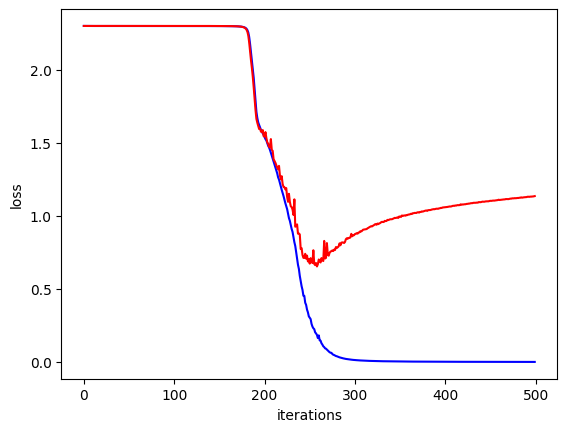

In [ ]:
iterations=500
plt.plot(range(0,iterations),train_history,'b')
plt.plot(range(0,iterations),val_history,'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

With

**[512,256,128,10], 0.01, 500,32:**

**After 300th epoch, training loss flattened after reaching to a value of 0% whereas val_loss increased after 300 th epoch but the loss value is than that of the initial loss. **

The losses reachedto around 0% with alower learning rate(0.01) and in a fewer number of epochs (500) in batch gradient descent than with a netwrk without the minibatch gradient as it took more than 2000epochs at a learning rate of 0.01 to get toaower loss values.

Other experiments

---



[512,256,128,10], 0.1, 250,32:

Reached to 0% by 140th epoch, training loss started increasing after 140th epoch. val loss reached toa value of 0.57 and fluctuated around that range after 140th epoch.

[512,256,128,10],lr= 0.1, 150,batch size=128, losses reached to a value of 0% and flattened by the end of last epochs with lot of fluctuations. Val_loss reacged 0.64 whereas train_lossreahed 0.002%

batch_size = 32  # Example batch size
learning_rate = 0.5
iterations = 50  # Number of epochs
nh = [512, 256, 128, 10], losses reached plateau toavalue of around 0% but with big spikes (fluctuations) before reaching there.


batch_size = 64  # Example batch size
learning_rate = 0.01
iterations = 50  # Number of epochs
nh = [512, 256, 128, 10], losses reached  a value of around 2.3%.

batch_size = 128  # Example batch size
learning_rate = 0.01
iterations = 50  & 150# Number of epochs
nh = [512, 256, 128, 10], losses reached  a value of around 2.3%.

batch_size = 32  # Example batch size
learning_rate = 0.01
iterations = 50  # Number of epochs
nh = [512, 256, 128, 10], losses reached  a value of around 2.3%.

batch_size = 64  # Example batch size
learning_rate = 0.1
iterations = 50  # Number of epochs
nh = [512, 256, 128, 10], losses converged till 35 the epoch and at 50th epoch recorded  a value of around 0.63% but with big spikes (fluctuations) .

batch_size = 32  # Example batch size
learning_rate = 0.1
iterations = 50  # Number of epochs
nh = [512, 256, 128, 10], training loss recorded  a value of around 0% but val_loss reached there with spikes (fluctuations) and flattened aftr 40th epoch.





#2- Update parameters using Nesterov Momentum

. The update rule for nesterov Momentum is as follows:
𝑣 = 𝜇 ∗ 𝑣 − 𝑙𝑒𝑎𝑟𝑛𝑖𝑛𝑔𝑅𝑎𝑡𝑒 ∗ 𝑔
𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟 = 𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟 + 𝜇 ∗ 𝑣 − 𝑙𝑒𝑎𝑟𝑛𝑖𝑛𝑔𝑅𝑎𝑡𝑒 ∗ 𝑔
Where 𝑔 is the gradient of loss with respect to the
𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟 𝑦𝑜𝑢 𝑤𝑎𝑛𝑡 𝑡𝑜 𝑢𝑝𝑑𝑎𝑡𝑒 (𝑖. 𝑒. , 𝑤𝑒𝑖𝑔ℎ𝑡𝑠 𝑎𝑛𝑑 𝑏𝑖𝑎𝑠𝑒𝑠) and 𝜇 ∈ [0,1] is momentum decay rate ( it
should be provided as input to the update_parameter method).
𝑣 is initially zero. In your initialize_parameters method, you should define a 𝑣 variable for each
parameter (i.e., weights and biases) with the same shape as the parameter and set it to zero.
Try re-training your neural network with different values of 𝜇 ( e.g., 0.9, 0.95, and 0.99) and interpret
the learning curves.
Answer the following question:
• Does Gradient Descent with Nesterov Momentum help improve your model ?

In [ ]:
def initialize_parameters(nx, nh):
    parameters = {}
    velocities = {}  # To store the velocities for Nesterov Momentum

    # Initialize weights and biases for the first layer (input to the first hidden layer)
    parameters['W1'] = tf.Variable(tf.random.uniform(shape=(nh[0], nx), minval=-0.01, maxval=0.01))
    parameters['b1'] = tf.Variable(tf.zeros((nh[0], 1)))

    # Initialize velocities (set to zero)
    velocities['vW1'] = tf.Variable(tf.zeros((nh[0], nx)))
    velocities['vb1'] = tf.Variable(tf.zeros((nh[0], 1)))

    for i in range(1, len(nh)):
        # Initialize weights and biases for hidden layers
        parameters['W' + str(i + 1)] = tf.Variable(tf.random.uniform(shape=(nh[i], nh[i - 1]), minval=-0.01, maxval=0.01))
        parameters['b' + str(i + 1)] = tf.Variable(tf.zeros((nh[i], 1)))

        # Initialize velocities (set to zero)
        velocities['vW' + str(i + 1)] = tf.Variable(tf.zeros((nh[i], nh[i - 1])))
        velocities['vb' + str(i + 1)] = tf.Variable(tf.zeros((nh[i], 1)))

    return parameters, velocities


In [ ]:
def update_parameters_velocities(parameters, velocities, gradients, learning_rate, mu):
    # Update parameters using Nesterov momentum
    for i,key in enumerate(parameters.keys()):
        v = velocities['v' + key]  # Current velocity
        g = gradients[i]  # Gradient with respect to the current parameter

        # Update velocity
        v.assign(mu * v - learning_rate * g)

        # Update parameters using Nesterov update rule
        # parameter = parameter + mu * v - learning_rate * g
        parameters[key].assign_add(mu * v - learning_rate * g)

    return parameters, velocities


 **Create neural network using mini-batch gradient descent with Nesterov momentum**

In [ ]:

# Define the neural network with mini-batch gradient descent and Nesterov momentum
def create_nn_nesterov(train_X, train_Y, val_X, val_Y, nh, learning_rate, iterations, batch_size, mu):
    # Initialize parameters and velocities
    parameters, velocities = initialize_parameters(train_X.shape[0], nh)
    train_loss_history = []
    val_loss_history = []

    for i in range(iterations):
        mini_batches = create_mini_batches(train_X, train_Y, batch_size)
        epoch_train_losses = []

        for (mini_batch_X, mini_batch_Y) in mini_batches:
            # Compute train loss and gradients for each mini-batch
            with tf.GradientTape() as tape:
                yhat_train = forward_pass(parameters, mini_batch_X)
                train_loss = compute_loss(mini_batch_Y, yhat_train)

            # Record mini-batch loss
            epoch_train_losses.append(train_loss.numpy())

            # Compute gradients and update parameters using Nesterov momentum
            gradients = compute_gradients(train_loss, parameters, tape)
            parameters, velocities = update_parameters_velocities(parameters, velocities, gradients, learning_rate, mu)

        # Average the loss over all mini-batches for the epoch
        avg_train_loss = np.mean(epoch_train_losses)
        train_loss_history.append(avg_train_loss)

        # Compute validation loss after each epoch
        yhat_val = forward_pass(parameters, val_X)
        val_loss = compute_loss(val_Y, yhat_val)
        val_loss_history.append(val_loss.numpy())

        print(f"Iteration {i}: Avg Train Loss: {avg_train_loss}, Validation Loss: {val_loss}")

    return parameters, train_loss_history, val_loss_history


In [ ]:
# Retraining with different values of mu(0.9,0.95,0.99)
parameters, train_history, val_history = create_nn_nesterov(X_train_T, Y_train_onehot_T, X_val_T, Y_val_onehot_T, [512,256,128,10], 0.01, 100, 32, mu=0.9)



Iteration 0: Avg Train Loss: 2.303270101547241, Validation Loss: 2.3023431301116943
Iteration 1: Avg Train Loss: 2.30326509475708, Validation Loss: 2.3029685020446777
Iteration 2: Avg Train Loss: 2.303194999694824, Validation Loss: 2.3030550479888916
Iteration 3: Avg Train Loss: 2.3030266761779785, Validation Loss: 2.303175926208496
Iteration 4: Avg Train Loss: 2.3030989170074463, Validation Loss: 2.3028829097747803
Iteration 5: Avg Train Loss: 2.3032822608947754, Validation Loss: 2.303347110748291
Iteration 6: Avg Train Loss: 2.3031845092773438, Validation Loss: 2.3028650283813477
Iteration 7: Avg Train Loss: 2.303176164627075, Validation Loss: 2.302734851837158
Iteration 8: Avg Train Loss: 2.3032619953155518, Validation Loss: 2.3027756214141846
Iteration 9: Avg Train Loss: 2.3033432960510254, Validation Loss: 2.3023765087127686
Iteration 10: Avg Train Loss: 2.3032283782958984, Validation Loss: 2.302560329437256
Iteration 11: Avg Train Loss: 2.3030993938446045, Validation Loss: 2.3032

With mu=0.9 (nesterov momentum)

Training loss at 100th epoch is 0%

Validation Loss: 61.78%

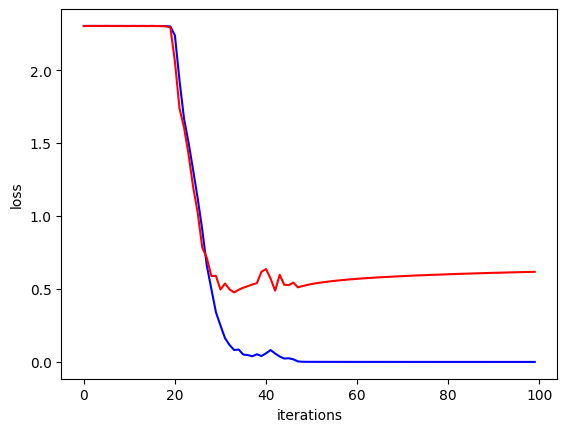

In [ ]:
iterations=100
plt.plot(range(0,iterations),train_history,'b')
plt.plot(range(0,iterations),val_history,'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

In [ ]:
parameters, train_history, val_history = create_nn_nesterov(X_train_T, Y_train_onehot_T, X_val_T, Y_val_onehot_T, [512,256,128,10], 0.01, 100, 32, mu=0.95)


Iteration 0: Avg Train Loss: 2.304382562637329, Validation Loss: 2.301478624343872
Iteration 1: Avg Train Loss: 2.304100513458252, Validation Loss: 2.302311420440674
Iteration 2: Avg Train Loss: 2.3038241863250732, Validation Loss: 2.3028249740600586
Iteration 3: Avg Train Loss: 2.3040525913238525, Validation Loss: 2.3021247386932373
Iteration 4: Avg Train Loss: 2.304029703140259, Validation Loss: 2.302335262298584
Iteration 5: Avg Train Loss: 2.303986072540283, Validation Loss: 2.3026602268218994
Iteration 6: Avg Train Loss: 2.3039228916168213, Validation Loss: 2.302624464035034
Iteration 7: Avg Train Loss: 2.3038313388824463, Validation Loss: 2.302823781967163
Iteration 8: Avg Train Loss: 2.3035330772399902, Validation Loss: 2.301973342895508
Iteration 9: Avg Train Loss: 2.3028650283813477, Validation Loss: 2.301985740661621
Iteration 10: Avg Train Loss: 2.299654483795166, Validation Loss: 2.289870262145996
Iteration 11: Avg Train Loss: 2.0773589611053467, Validation Loss: 1.71470558

Retraining With gradient descnet of nesterov momentum=0.95:

training loss is 2.5e-05 =0.00%

val_loss: 0.4769=47.69%

When compared with trained model at mu=0.9, val_loss decreased from 67 % to 47.5 with higher momentum value

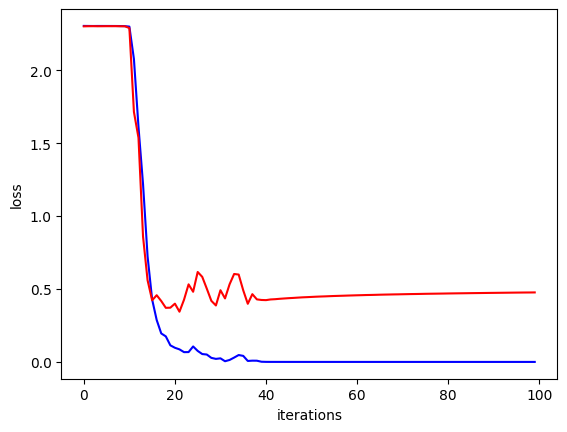

In [ ]:
iterations=100
plt.plot(range(0,iterations),train_history,'b')
plt.plot(range(0,iterations),val_history,'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

In [ ]:
parameters, train_history, val_history = create_nn_nesterov(X_train_T, Y_train_onehot_T, X_val_T, Y_val_onehot_T, [512,256,128,10], 0.01, 100, 32, mu=0.99)

Iteration 0: Avg Train Loss: 2.3060641288757324, Validation Loss: 2.305968999862671
Iteration 1: Avg Train Loss: 2.307396173477173, Validation Loss: 2.302996873855591
Iteration 2: Avg Train Loss: 2.307154655456543, Validation Loss: 2.304307699203491
Iteration 3: Avg Train Loss: 2.3068363666534424, Validation Loss: 2.302562952041626
Iteration 4: Avg Train Loss: 2.2333738803863525, Validation Loss: 1.9191988706588745
Iteration 5: Avg Train Loss: 1.6480505466461182, Validation Loss: 1.3150274753570557
Iteration 6: Avg Train Loss: 1.0364594459533691, Validation Loss: 0.9204198718070984
Iteration 7: Avg Train Loss: 0.6185063123703003, Validation Loss: 0.6422734260559082
Iteration 8: Avg Train Loss: 0.5050686597824097, Validation Loss: 0.636395275592804
Iteration 9: Avg Train Loss: 0.4238060414791107, Validation Loss: 0.47102591395378113
Iteration 10: Avg Train Loss: 0.3406403660774231, Validation Loss: 0.45993348956108093
Iteration 11: Avg Train Loss: 0.31324413418769836, Validation Loss: 0

KeyboardInterrupt: 

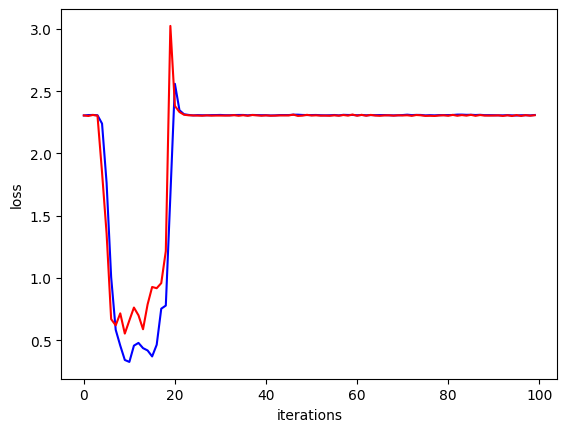

In [ ]:
iterations=100
plt.plot(range(0,iterations),train_history,'b')
plt.plot(range(0,iterations),val_history,'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

With mu=0.99, losses converged but were higher tahn the earlier losses obtained with other models trained above.

 *Gradient Descent with Nesterov Momentum helped in the improvement of  this model in  **terms of number of epochs **taken for training which are as few as a 100 as it just took 500 epochs to get to a loss values reached with a minibatch gradient descent of 500 epochs. *

 Gradient Descent with Nesterov Momentum of 0.9 and 0.95 resulted inlower losses at fewer epochs.

#3- Reduce Learning Rate on Plateau
Reduce the learning rate by half if no improvement is seen in validation loss for 10 epochs.
Should monitor and keep track of the best validation loss and the parameters for the model with that
loss. If no improvement is seen in validation loss for 10 epochs, then reduce the learning rate by 0.5
and continue the training with that learning rate. Stop training if the learning rate is reduced to
minimum value ( e.g., 1e-4) and return the parameters with the lowest validation loss.


In [ ]:
#Referred google
def create_nn_plateau(train_X, train_Y, val_X, val_Y, nh, initial_lr, iterations, batch_size, mu, min_lr=1e-4, patience=10):
    # Initialize parameters and velocities
    parameters, velocities = initialize_parameters(train_X.shape[0], nh)
    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')  # Best validation loss initialized to infinity
    best_parameters = copy.deepcopy(parameters)  # Best parameters initialized as a copy
    best_epoch = -1  # Epoch with the best validation loss
    lr = initial_lr  # Start with the initial learning rate
    plateau_counter = 0  # Counter to track how many epochs without improvement

    for i in range(iterations):
        mini_batches = create_mini_batches(train_X, train_Y, batch_size)
        epoch_train_losses = []

        # Train on each mini-batch
        for (mini_batch_X, mini_batch_Y) in mini_batches:
            # Compute train loss and gradients for each mini-batch
            with tf.GradientTape() as tape:
                yhat_train = forward_pass(parameters, mini_batch_X)
                train_loss = compute_loss(mini_batch_Y, yhat_train)

            # Record mini-batch loss
            epoch_train_losses.append(train_loss.numpy())

            # Compute gradients and update parameters using Nesterov momentum
            gradients = compute_gradients(train_loss, parameters, tape)
            parameters, velocities = update_parameters_velocities(parameters, velocities, gradients, lr, mu)

        # Average the loss over all mini-batches for the epoch
        avg_train_loss = np.mean(epoch_train_losses)
        train_loss_history.append(avg_train_loss)

        # Compute validation loss after each epoch
        yhat_val = forward_pass(parameters, val_X)
        val_loss = compute_loss(val_Y, yhat_val)
        avg_val_loss = val_loss.numpy()
        val_loss_history.append(avg_val_loss)

        print(f"Iteration {i}: Avg Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Learning Rate: {lr}")

        # Check for improvement in validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_parameters = copy.deepcopy(parameters)  # Save the best parameters
            best_epoch = i
            plateau_counter = 0  # Reset plateau counter if there is improvement
        else:
            plateau_counter += 1

        # Reduce learning rate if no improvement for `patience` epochs
        if plateau_counter >= patience:
            if lr > min_lr:
                lr = max(lr * 0.5, min_lr)  # Reduce learning rate by half but ensure it's not below min_lr
                print(f"Reducing learning rate to {lr}")
                plateau_counter = 0  # Reset plateau counter after reducing learning rate
            else:
                print(f"Learning rate reduced to minimum value ({min_lr}). Stopping training.")
                break  # Stop training if learning rate reaches minimum value

    print(f"Training completed. Best validation loss: {best_val_loss} at epoch {best_epoch}.")
    return best_parameters, train_loss_history, val_loss_history


In [ ]:
best_parameters, train_history, val_history = create_nn_plateau(
    X_train_T, Y_train_onehot_T,
    X_val_T, Y_val_onehot_T,
    [512,256,128,10],
    initial_lr=0.01,
    iterations=500,
    batch_size=32,
    mu=0.9,
    min_lr=1e-4,
    patience=10
)


Iteration 0: Avg Train Loss: 2.303183078765869, Validation Loss: 2.30212140083313, Learning Rate: 0.01
Iteration 1: Avg Train Loss: 2.303197145462036, Validation Loss: 2.3018791675567627, Learning Rate: 0.01
Iteration 2: Avg Train Loss: 2.3034470081329346, Validation Loss: 2.3026809692382812, Learning Rate: 0.01
Iteration 3: Avg Train Loss: 2.3032634258270264, Validation Loss: 2.3024744987487793, Learning Rate: 0.01
Iteration 4: Avg Train Loss: 2.3032782077789307, Validation Loss: 2.3027303218841553, Learning Rate: 0.01
Iteration 5: Avg Train Loss: 2.303215265274048, Validation Loss: 2.3028781414031982, Learning Rate: 0.01
Iteration 6: Avg Train Loss: 2.303241014480591, Validation Loss: 2.3030645847320557, Learning Rate: 0.01
Iteration 7: Avg Train Loss: 2.3033037185668945, Validation Loss: 2.3028738498687744, Learning Rate: 0.01
Iteration 8: Avg Train Loss: 2.303256034851074, Validation Loss: 2.3024849891662598, Learning Rate: 0.01
Iteration 9: Avg Train Loss: 2.303422212600708, Valid

In [ ]:
print("Best parameters obtained at the lowest validation loss:")

for param_name, param_value in best_parameters.items():
    print(f"{param_name}: {param_value}")

Best parameters obtained at the lowest validation loss:
W1: <tf.Variable 'Variable:0' shape=(512, 1600) dtype=float32, numpy=
array([[ 3.9666751e-03,  5.7922327e-03,  5.3362604e-03, ...,
         1.1658204e-04, -3.3428106e-03,  3.5822727e-03],
       [-5.0889268e-03,  5.6601865e-03, -5.0403416e-04, ...,
         3.0882021e-03,  5.5813994e-03, -5.1668910e-03],
       [ 8.5346308e-03,  4.8556891e-03, -3.4992457e-03, ...,
        -1.0260696e-02, -7.1898331e-03,  6.2835421e-03],
       ...,
       [ 9.3769208e-03, -1.8392928e-05, -4.5328862e-03, ...,
         2.1075029e-03, -8.6317528e-03,  5.9649483e-03],
       [ 2.8624628e-03, -4.8496947e-03,  8.8547654e-03, ...,
         3.1564054e-03, -2.0551691e-03, -9.7373379e-03],
       [-6.5686442e-03, -8.8593718e-03,  1.5980047e-03, ...,
         5.0250004e-04,  9.9263545e-03,  3.1817704e-03]], dtype=float32)>
b1: <tf.Variable 'Variable:0' shape=(512, 1) dtype=float32, numpy=
array([[-2.37572618e-04],
       [ 1.02909952e-02],
       [ 2.0744716

Iteration 40: Avg Train Loss: 0.0065611484460532665, Validation Loss: 0.49307766556739807, Learning Rate: 0.01
Reducing learning rate to 0.005

After this iteration, learning reduced after every 10 epochs.

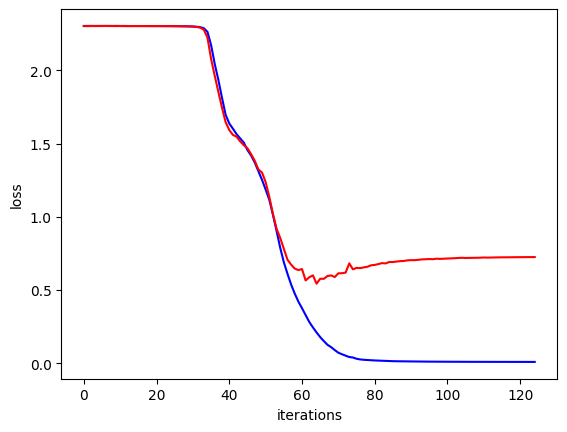

In [ ]:
iterations=125
plt.plot(range(0,iterations),train_history,'b')
plt.plot(range(0,iterations),val_history,'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

4. Add Dropout Regularization (5pt)
To add dropout regularization, you should modify the forward pass when applied to the training data and
multiply the output of neurons in each layer (Z) by 1/𝑝* a random matrix of zeros and ones sampled from a
Bernoulli distribution with probability 𝑝. Where (𝑝.=1- dropout_rate) is the probability of keeping a neuron. To
get a random matrix of zeros and ones with the same shape as Z, you can first create a Bernoulli distribution
with probability 𝑝 using tfp.distributions.Bernoulli then sample from this distribution.
Note: The dropout should only be applied during training that is, it should only be applied to the training data.
The dropout should NOT be applied at the time of inference that is, it should NOT be applied to the validation
and test sets.
Also note that the dropout should NOT be applied to the final layer because we do not want to drop any
neuron in the final layer ( the final layer in a multi-class classification problem should have as many neurons
as the number of output classes)
Re-train the model with dropout regularization ( use a dropout rate between 0.2-0.5 ( that is a keep
probability 𝑝 between 0.8-0.5). Answer the following question:
• Does dropout regularization help reduce the gap between train and validation losses?

#Note:
 The forward_pass_with dropout should only be applied to the training data  The dropout should NOT be applied to the validation and test sets.  Also dropout is supposed to reduce the gap between training and validation losses and not increase it.

================================THE END=====================